# Data Processing

In [1]:
pip install pybaseball

     |████████████████████████████████| 415 kB 8.4 MB/s 
     |████████████████████████████████| 291 kB 46.5 MB/s 
     |████████████████████████████████| 961 kB 27.7 MB/s 


In [2]:
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import statcast
from pybaseball import cache

cache.enable()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def get_statcast_data(pitcher_csv, batter_csv):

  '''
  function for obtaining dataframes from Statcast

  parameters_type:
    (pitcher_csv, batter_csv) --> pitcher_dataframe, batter_dataframe

  important_note:
    these Statcast dataframes will be concatenated to pybaseball dataframes at the end.
  '''

  # read pitcher/batter csv file
  df_pitchers = pd.read_csv(pitcher_csv) 
  df_batters = pd.read_csv(batter_csv)

  # sort a df by 'last name' and 'run_value_per_100'
  # drop unnecessary columns
  df_pitchers =  df_pitchers.sort_values(by = ['last_name', 'run_value_per_100'], ascending = (True, False)).drop(['pitch_type', 'run_value', 'team_name_alt', 
                                                                                                                   'est_ba', 'est_slg', 'est_woba',
                                                                                                                   'hard_hit_percent', 'pitches',
                                                                                                                   'pitch_usage', 'pa', 'put_away',
                                                                                                                   ' first_name', 'last_name'], axis =1)
  
  df_batters =  df_batters.sort_values(by = ['last_name', 'run_value_per_100'], ascending = (True, False)).drop(['pitch_type', 'run_value', 'team_name_alt',
                                                                                                                 'est_ba', 'est_slg', 'est_woba',
                                                                                                                 'hard_hit_percent', 'pitches',
                                                                                                                 'pitch_usage', 'pa', 'put_away',
                                                                                                                 ' first_name', 'last_name'], axis =1)

  # rename some columns in order to merge with pybaseball dataframe (for future purposes)                                               
  df_pitchers.rename(columns={'run_value_per_100': 'p_run_value_per_100',
                              'ba':'p_ba',
                              'slg':'p_slg', 
                              'woba': 'p_woba', 
                              'whiff_percent': 'p_whiff_percent', 
                              'k_percent': 'p_k_percent',
                              'player_id': 'pitcher_id',
                              'pitch_name':'pitch_type'}, inplace=True)
  
  df_batters.rename(columns={'run_value_per_100': 'b_run_value_per_100', 
                             'ba':'b_ba', 
                             'slg':'b_slg', 
                             'woba': 'b_woba', 
                             'whiff_percent': 'b_whiff_percent', 
                             'k_percent': 'b_k_percent',
                             'player_id': 'batter_id',
                             'pitch_name':'pitch_type'}, inplace=True)
                                               
  return df_pitchers, df_batters

In [5]:
def get_pybaseball_data(start_date, end_date, pitcher_data, batter_data):

    '''
    function for obtaining pybaseball dataframes and finalizing into a final dataframe

    parameters_type:
    (start_date, end_date, pitcher_dataframe, batter_dataframe) --> final dataframe

    important_note:
    pitcher_dataframe & batter_dataframe are the dataframes obtained using get_statcast_data function!
    '''


    # API call using pybaseball library
    data = statcast(start_dt=start_date, end_dt=end_date)


    # drop unnecessary columns
    data = data.drop(['release_speed', 'release_pos_x', 'release_pos_z', 'spin_dir',
                    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated',
                    'zone', 'game_type', 'hit_location', 'bb_type', 'pfx_x', 'pfx_z',
                    'plate_x', 'plate_z','hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                    'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
                    'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
                    'release_spin_rate', 'release_extension', 'pitcher.1', 'fielder_2.1', 'fielder_3',
                    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
                    'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
                    'bat_score', 'fld_score', 'post_bat_score', 'post_fld_score', 
                    'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis', 'delta_home_win_exp', 
                    'delta_run_exp', 'pitch_type'], axis = 1)

    # rename to follow the same convention as Statcast dataframes
    data.rename(columns={'player_name': 'pitcher_name'}, inplace=True)


    # combine ball_count and save as one column called 'count'
    # follow the basic convention --> 'ball'-'strike'
    # ie) '1-2' : 1 ball, 2 strikes

    count = []

    for ball, strike in zip(data['balls'].tolist(), data['strikes'].tolist()):
        combined = str(ball) + '-' + str(strike)
        count.append(combined)

    data['count'] = count
    data = data.drop(['balls', 'strikes'], axis=1)


    # reorganize runners on bases columns
    # 1 --> runner is on the base
    # 0 --> runner is not on the base
    # ie) if runners are on the first and third base only,
    #       'on_3b' : 1
    #       'on_2b' : 0
    #       'on_1b' : 1

    values = {'on_3b': 0, 'on_2b': 0, 'on_1b': 0}
    data = data.fillna(value=values)

    on_third_base = []
    on_second_base = []
    on_first_base = []

    for i in data['on_3b'].tolist():
        if i != 0:
            on_third_base.append(1)
        else:
            on_third_base.append(0)

    for j in data['on_2b'].tolist(): 
        if j != 0:
            on_second_base.append(1)
        else:
            on_second_base.append(0)

    for k in data['on_1b'].tolist():
        if k != 0:
            on_first_base.append(1)
        else:
            on_first_base.append(0)

    data['on_3b'] = on_third_base

    data['on_2b'] = on_second_base

    data['on_1b'] = on_first_base


    # exception handling: removing the row with infeasible ball_count (ie. 4-1)
    infeasible_indices = data[data['count']=='4-1'].index

    if len(infeasible_indices) > 0:
        data = data.drop(infeasible_indices, axis=0)


    # extract batter names from 'des' column & save under a column called 'batter_name'
    # key_note:
    #   first two words are the batter names

    str_des = []
    for des in data['des'].tolist():
        str_des.append(str(des))

    data['des'] = str_des

    data['batter_name'] = data['des'].apply(lambda x: ', '.join(x.split()[:2][::-1]))
    data= data.drop('des', axis =1) # drop 'des' column since it's not needed anymore


    # reorder the columns
    data = data[[
    'game_pk',
    'game_date',
    'game_year',
    'home_team',
    'away_team',
    'pitcher_name',
    'p_throws',
    'pitcher',
    'pitch_number',
    'batter_name',
    'stand',
    'batter',
    'at_bat_number',
    'inning',
    'inning_topbot',
    'outs_when_up',
    'count',
    'on_3b',
    'on_2b',
    'on_1b',
    'type',
    'pitch_name',
    'events',
    'description',
    'home_score',
    'away_score',
    'post_home_score',
    'post_away_score'
    ]]


    # rename few columns in the same convention that is used in Statcast dataframe
    data.rename(columns={'pitcher': 'pitcher_id',
                       'batter':'batter_id', 
                       'game_pk': 'game_id', 
                       'pitch_name':'pitch_type',
                       'stand':'b_bats'}, inplace=True)


    # extra EDA process, in which similar pitch_types are clustered into one pitch_type
    data.replace({'Knuckle Curve':'Curveball',
                'Split-Finger': 'Splitter',
                '2-Seam Fastball': 'Sinker',
                '4-Seam Fastball' : '4-Seamer'}, inplace=True)

    # drop some uncommon pitch_types (only ~1% of the entire dataset)
    data = data.drop(data[data['pitch_type'] == 'Knuckleball'].index)
    data = data.drop(data[data['pitch_type'] == 'Eephus'].index)
    data = data.drop(data[data['pitch_type'] == 'Fastball'].index)

    # drop additional missing rows
    data['events'].fillna('None', inplace=True)
    data.dropna(axis='rows', inplace=True)

    # merge pybaseball dataframe with Statcast dataframe
    data = data.merge(pitcher_data, on=['pitcher_id','pitch_type'])
    data = data.merge(batter_data, on=['batter_id','pitch_type'])
    data.drop(columns=['events', 'description'], axis=1, inplace=True)

    
    # to make data into a correct chronological, play-by-play format, we sort the columns accordingly
    data = data.sort_values(by = ['game_date', 'game_id', 'inning', 'inning_topbot', 'at_bat_number', 'pitch_number'], 
                         ascending = (True, True, True, False, True, True))



    return data

# Further Data Processing 

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
###### 2019 DATA ######
pitcher_data, batter_data = get_statcast_data('/content/gdrive/MyDrive/Engineering Science/Year 2/Summer/APS360/APS360 - Group Project/Data/2019/Pitch-Arsenal-Pitchers-2019.csv', '/content/gdrive/MyDrive/Engineering Science/Year 2/Summer/APS360/APS360 - Group Project/Data/2019/Pitch-Arsenal-Batters-2019.csv')
data_2019 = get_pybaseball_data('2019-03-20', '2019-09-29' , pitcher_data, batter_data)

###### 2020 DATA ######
pitcher_data, batter_data = get_statcast_data('/content/gdrive/MyDrive/Engineering Science/Year 2/Summer/APS360/APS360 - Group Project/Data/2020/Pitch-Arsenal-Pitchers-2020.csv', '/content/gdrive/MyDrive/Engineering Science/Year 2/Summer/APS360/APS360 - Group Project/Data/2020/Pitch-Arsenal-Batters-2020.csv')
data_2020 = get_pybaseball_data('2020-07-23', '2020-09-27' , pitcher_data, batter_data)

###### 2021 DATA ######
pitcher_data, batter_data = get_statcast_data('/content/gdrive/MyDrive/Engineering Science/Year 2/Summer/APS360/APS360 - Group Project/Data/2021/Pitch-Arsenal-Pitchers-2021.csv', '/content/gdrive/MyDrive/Engineering Science/Year 2/Summer/APS360/APS360 - Group Project/Data/2021/Pitch-Arsenal-Batters-2021.csv')
data_2021 = get_pybaseball_data('2021-04-01', '2021-06-15', pitcher_data, batter_data)

###### CONCATENATE 2019, 2020, 2021 DATA ######
frames = [data_2019, data_2020, data_2021]

final_df = pd.concat(frames)
final_df = final_df.groupby('game_id').filter(lambda x : len(x) >= 200) # Kept rows where there were more than 200 pitches
# Less than 200 pitches accounted for less than 2 % of the data


This is a large query, it may take a moment to complete


100%|██████████| 194/194 [04:11<00:00,  1.30s/it]


This is a large query, it may take a moment to complete


100%|██████████| 67/67 [01:21<00:00,  1.22s/it]


This is a large query, it may take a moment to complete


100%|██████████| 76/76 [01:28<00:00,  1.16s/it]


In [8]:
final_df.columns
data_2022 = statcast('2019-04-01', '2019-04-01')
data_2022['pitch_number']

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


3095    4
3248    3
3317    2
3384    1
3500    1
       ..
3310    1
3472    4
3495    3
3641    2
3760    1
Name: pitch_number, Length: 3844, dtype: Int64

In [9]:
data_2022['pitch_number'].unique()

# pitch_number == at_bat_count

<IntegerArray>
[4, 3, 2, 1, 7, 6, 5, 8, 12, 11, 10, 9]
Length: 12, dtype: Int64

In [10]:
final_df[final_df['pitcher_name'] == 'Scherzer, Max']['pitcher_id']

362408    453286
362407    453286
110421    453286
345426    453286
345425    453286
           ...  
173397    453286
172030    453286
174878    453286
173396    453286
226963    453286
Name: pitcher_id, Length: 4246, dtype: Int64

In [11]:
###### FIND THE PROPER ORDER FOR EACH GAME_ID'S COUNTS (FOR FUTURE SPLITTING PURPOSES) ######

dfd = pd.DataFrame(final_df['game_id'].value_counts())
dfd['count'] = dfd.index.values
dfd.rename(columns = {'game_id': 'count', 'count':'game_id'}, inplace = True)
dfd.head()

dfd_dict = {}

for i, j in zip(dfd['count'].tolist(), dfd['game_id'].tolist()):
    dfd_dict[j] = i


actual_id_count = {}

for g_id in np.array(final_df['game_id'].unique()).tolist():
    if g_id in dfd_dict:
        actual_id_count[g_id] = dfd_dict[g_id]
    else:
        pass

###### PLAYER ID MAPPING ######

player_dict = {}

for pitcher_name, batter_name, p_id, b_id in zip(final_df['pitcher_name'].unique().tolist(), final_df['batter_name'].unique().tolist(),
                                                np.array(final_df['pitcher_id'].unique()).tolist(), np.array(final_df['batter_id'].unique()).tolist()):
    player_dict[p_id] = pitcher_name
    player_dict[b_id] = batter_name
    
print(list(player_dict.keys())[list(player_dict.values()).index('Scherzer, Max')])
# 501571

501571


In [12]:
###### SHUFFLING DATA ######


lst_value_cnt = list(actual_id_count.values())     

lst_value_cnt_sum= []
for i in range(len(lst_value_cnt)):
    lst_value_cnt_sum.append(sum(lst_value_cnt[:i+1]))


lst = final_df.values.tolist()

val_check = 0
idx = 0
tmp_idx = 0

final_lst = []
for val in lst:
    if val_check != val[0]:
        temp = lst[tmp_idx:lst_value_cnt_sum[idx]]
        tmp_idx = lst_value_cnt_sum[idx]
        idx += 1
        final_lst.append(temp)
        val_check = val[0]

    else:
        pass

import random 
random.seed(101)
random.shuffle(final_lst)
shuffled_lst = final_lst


###### CREATE 'MINI-DATAFRAMES' BY ITERATING THROUGH THE LIST, AND THEN MERGE INTO FINAL DATAFRAME ######

lst_of_randomized_dfs = []

for mini_df in shuffled_lst: 
    df = pd.DataFrame(mini_df,columns=final_df.columns.tolist())
    lst_of_randomized_dfs.append(df) 

shuffled_df = pd.concat(lst_of_randomized_dfs)
shuffled_df


###### DROP SOME COLUMNS FOR THE LAST TIME (SOME COLUMNS EXISTED PREVIOUSLY PURELY FOR SORTING PURPOSES))######
shuffled_df.columns
shuffled_df = shuffled_df.drop(['pitch_number','at_bat_number', 'pitcher_name', 'batter_name', 'game_year'], axis = 1)

# DROP PITCH_NUMBER LATER

###### REORDER DATAFRAME INTO STATIONARY + SEQUENTIAL COLUMNS  (BASIC IDEA)--> [[STATIONARY COLUMNS], [SEQUENTIAL COLUMNS], [LABEL]] ######

shuffled_df = shuffled_df[['pitcher_id', 'batter_id', 'p_run_value_per_100', 'p_ba',
       'p_slg', 'p_woba', 'p_whiff_percent', 'p_k_percent',
       'b_run_value_per_100', 'b_ba', 'b_slg', 'b_woba', 'b_whiff_percent',
       'b_k_percent', 'game_id', 'home_team', 'away_team', 'inning', 'inning_topbot', 'outs_when_up', 'count',
       'on_3b', 'on_2b', 'on_1b','type', 'home_score', 'away_score',
       'post_home_score', 'post_away_score', 'pitch_type']]

In [13]:
# 453286
shuffled_df = shuffled_df[shuffled_df['pitcher_id'] == 453286]
shuffled_df = shuffled_df[['batter_id', 'p_run_value_per_100', 'p_ba',
       'p_slg', 'p_woba', 'p_whiff_percent', 'p_k_percent',
       'b_run_value_per_100', 'b_ba', 'b_slg', 'b_woba', 'b_whiff_percent',
       'b_k_percent', 'inning', 'inning_topbot', 'outs_when_up', 'count',
       'on_3b', 'on_2b', 'on_1b','type', 'pitch_type']]



In [14]:
### TEMP ####

list_of_rows = []
df_list = []
        
for i in range(len(shuffled_df) - 1):
    curr_id = shuffled_df.iloc[[i]].values[0,0]
    next_id = shuffled_df.iloc[[i + 1]].values[0,0]
    
    if curr_id == next_id:
        temp_df = shuffled_df.iloc[[i]].values[0] # add loc here for columns
        list_of_rows.append(temp_df)
    
    if curr_id != next_id:
        temp_df = shuffled_df.iloc[[i]].values[0]
        list_of_rows.append(temp_df)
        df_list.append(pd.DataFrame(list_of_rows, columns = shuffled_df.columns))
        list_of_rows.clear()
    
    else:
        pass
        

df_list[1]

,batter_id,p_run_value_per_100,p_ba,p_slg,p_woba,p_whiff_percent,p_k_percent,b_run_value_per_100,b_ba,b_slg,b_woba,b_whiff_percent,b_k_percent,inning,inning_topbot,outs_when_up,count,on_3b,on_2b,on_1b,type,pitch_type
0,592178,-1.2,0.223,0.415,0.305,27.4,33.3,2.4,0.319,0.712,0.476,22.5,22.1,1,Top,0,0-0,0,0,1,X,4-Seamer


In [15]:
# shuffled_df[['pitch_number', 'batter_id']].value_counts().tolist()[0]
shuffled_df.head(20)

,batter_id,p_run_value_per_100,p_ba,p_slg,p_woba,p_whiff_percent,p_k_percent,b_run_value_per_100,b_ba,b_slg,b_woba,b_whiff_percent,b_k_percent,inning,inning_topbot,outs_when_up,count,on_3b,on_2b,on_1b,type,pitch_type
0,656941,0.3,0.290,0.516,0.374,23.3,14.7,-0.9,0.196,0.339,0.263,39.0,45.2,1,Top,0,0-0,0,0,0,B,Curveball
1,656941,-1.2,0.223,0.415,0.305,27.4,33.3,0.8,0.234,0.557,0.378,21.7,19.5,1,Top,0,1-0,0,0,0,B,4-Seamer
2,656941,-0.1,0.262,0.475,0.342,26.4,37.9,-1.3,0.243,0.432,0.324,26.8,25.0,1,Top,0,2-0,0,0,0,B,Cutter
3,656941,-1.2,0.223,0.415,0.305,27.4,33.3,0.8,0.234,0.557,0.378,21.7,19.5,1,Top,0,3-0,0,0,0,B,4-Seamer
4,592178,-1.2,0.223,0.415,0.305,27.4,33.3,2.4,0.319,0.712,0.476,22.5,22.1,1,Top,0,0-0,0,0,1,X,4-Seamer
5,519203,-0.1,0.262,0.475,0.342,26.4,37.9,4.6,0.353,0.706,0.505,18.2,13.6,1,Top,0,0-0,0,1,1,B,Cutter
6,519203,-0.1,0.262,0.475,0.342,26.4,37.9,4.6,0.353,0.706,0.505,18.2,13.6,1,Top,0,1-0,0,1,1,S,Cutter
7,519203,-1.2,0.223,0.415,0.305,27.4,33.3,1.7,0.287,0.529,0.399,17.5,15.8,1,Top,0,1-1,0,1,1,B,4-Seamer
8,519203,-0.1,0.262,0.475,0.342,26.4,37.9,4.6,0.353,0.706,0.505,18.2,13.6,1,Top,0,2-1,0,1,1,S,Cutter
9,519203,0.7,0.240,0.384,0.291,38.8,37.1,0.2,0.253,0.379,0.322,23.3,10.0,1,Top,0,2-2,0,1,1,X,Changeup


In [16]:
###### ONE-HOT ENCODING ######

shuffled_df = pd.get_dummies(shuffled_df)

### LEAVE THIS LINE DO NOT DELETEEEE
# shuffled_df.columns

# def normalize(df):
#     result = df.copy()
#     for feature_name in df.columns:
#         max_value = df[feature_name].max()
#         min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
#     return result


# shuffled_df = normalize(shuffled_df)

shuffled_df.columns

Index(['batter_id', 'p_run_value_per_100', 'p_ba', 'p_slg', 'p_woba',
       'p_whiff_percent', 'p_k_percent', 'b_run_value_per_100', 'b_ba',
       'b_slg', 'b_woba', 'b_whiff_percent', 'b_k_percent', 'inning',
       'outs_when_up', 'on_3b', 'on_2b', 'on_1b', 'inning_topbot_Bot',
       'inning_topbot_Top', 'count_0-0', 'count_0-1', 'count_0-2', 'count_1-0',
       'count_1-1', 'count_1-2', 'count_2-0', 'count_2-1', 'count_2-2',
       'count_3-0', 'count_3-1', 'count_3-2', 'type_B', 'type_S', 'type_X',
       'pitch_type_4-Seamer', 'pitch_type_Changeup', 'pitch_type_Curveball',
       'pitch_type_Cutter', 'pitch_type_Slider'],
      dtype='object')

In [17]:
list_of_rows = []
df_list = []
        
for i in range(len(shuffled_df) - 1):
    curr_id = shuffled_df.iloc[[i]].values[0,0]
    next_id = shuffled_df.iloc[[i + 1]].values[0,0]
    
    if curr_id == next_id:
        temp_df = shuffled_df.iloc[[i]].values[0] # add loc here for columns
        list_of_rows.append(temp_df)
    
    if curr_id != next_id:
        temp_df = shuffled_df.iloc[[i]].values[0]
        list_of_rows.append(temp_df)
        df_list.append(pd.DataFrame(list_of_rows, columns = shuffled_df.columns))
        list_of_rows.clear()
    
    else:
        pass
        

In [18]:
# df_list[0][:4].loc[:, 'batter_id': 'b_k_percent']
df_list[1]

,batter_id,p_run_value_per_100,p_ba,p_slg,p_woba,p_whiff_percent,p_k_percent,b_run_value_per_100,b_ba,b_slg,b_woba,b_whiff_percent,b_k_percent,inning,outs_when_up,on_3b,on_2b,on_1b,inning_topbot_Bot,inning_topbot_Top,count_0-0,count_0-1,count_0-2,count_1-0,count_1-1,count_1-2,count_2-0,count_2-1,count_2-2,count_3-0,count_3-1,count_3-2,type_B,type_S,type_X,pitch_type_4-Seamer,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Cutter,pitch_type_Slider
0,592178.0,-1.2,0.223,0.415,0.305,27.4,33.3,2.4,0.319,0.712,0.476,22.5,22.1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [19]:
df_final = []

for df in df_list:
    df_length = df.shape[0]
    if df_length <= 1:
        continue
    for i in range(2,df_length+1):
        df_temp = df[:i]
        label = list(df_temp.iloc[i-1, 35:40])
        stationary = list(df_temp.iloc[i-1, 0:13])
        df_temp.drop(df_temp.columns[0:13], axis=1, inplace=True)
        df_temp.drop(df_temp.columns[35:40], axis=1, inplace=True)
        df_temp.reset_index(drop=True, inplace=True)
        df_final += [(df_temp[:i-1], stationary, label)]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
# df_list[0][:2].iloc[2-1, 13:35]
# temp = df_list[0][:2]
# # temp = temp.drop(temp.columns[0:13], axis = 1)
# # temp = temp.drop(temp.columns[35:40], axis = 1)
# # temp = temp.reset_index(drop=True)
# temp.iloc[2-1, 0:13]

In [21]:
max_length = 0 
for i in range(len(df_final)):
    if max_length < len(df_final[i][0]):
        max_length = len(df_final[i][0])
    else:
        pass
print(max_length)

10


In [22]:
pitch_tensors = []

for data in df_final:
    tens = data[0].values
    pitch_tensors += [(tens.astype(float), data[1], data[2])]

In [23]:
df_final_by_type = [[] for _ in range(len(pitch_tensors[0][2]))]

for row in pitch_tensors:
    max_idx = np.asarray(row[2]).argmax()
    df_final_by_type[max_idx] += [row]

In [24]:
for row in df_final_by_type:
    print(len(row))

1470
553
191
276
595


In [25]:
# DO NOT RUN THIS MORE THAN ONCE

df_final_by_type[0] *= 2
df_final_by_type[1] *= 5
df_final_by_type[2] *= 14
df_final_by_type[3] *= 10
df_final_by_type[4] *= 5


df_final_types_combined = []

for row in df_final_by_type:
    df_final_types_combined.extend(row)

In [26]:
for row in df_final_by_type:
    print(len(row))

2940
2765
2674
2760
2975


In [27]:
for row in df_final_types_combined:
    print('======================================')
    print(row[0])
    break

[[1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0.]]


In [28]:
tensors_final = [[] for _ in range(14)]

for row in df_final_types_combined:
    idx = row[0].shape[0] - 1
    tensors_final[idx] += [row]


In [29]:
for tensors in tensors_final:
    print('===================')
    print(len(tensors))

4521
3749
2728
1691
893
329
132
55
11
5
0
0
0
0


In [30]:
# DO NOT RUN THIS MORE THAN ONCE

tensors_final[2] *= 2
tensors_final[3] *= 3
tensors_final[4] *= 6
tensors_final[5] *= 15
tensors_final[6] *= 57



In [31]:
for tensors in tensors_final:
    print('===================')
    print(len(tensors))

4521
3749
5456
5073
5358
4935
7524
55
11
5
0
0
0
0


In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class PitchDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        pitch_data = self.data_list[idx][0]
        stationary_data = self.data_list[idx][1]
        label = self.data_list[idx][2]
        label_idx = np.asarray(label).argmax()
        return pitch_data, np.asarray(stationary_data, dtype=np.float64), label_idx.astype(np.float64)
    
    
    
from __future__ import print_function
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms


class MyIter(object):
  """An iterator."""
  def __init__(self, my_loader):
    self.my_loader = my_loader
    self.loader_iters = [iter(loader) for loader in self.my_loader.loaders]

  def __iter__(self):
    return self

  def __next__(self):
    # When the shortest loader (the one with minimum number of batches)
    # terminates, this iterator will terminates.
    # The `StopIteration` raised inside that shortest loader's `__next__`
    # method will in turn gets out of this `__next__` method.
    batches = [loader_iter.next() for loader_iter in self.loader_iters]
    return self.my_loader.combine_batch(batches)

  # Python 2 compatibility
  next = __next__

  def __len__(self):
    return len(self.my_loader)

  
class MyLoader(object):
  """This class wraps several pytorch DataLoader objects, allowing each time 
  taking a batch from each of them and then combining these several batches 
  into one. This class mimics the `for batch in loader:` interface of 
  pytorch `DataLoader`.
  Args: 
    loaders: a list or tuple of pytorch DataLoader objects
  """
  def __init__(self, loaders):
    self.loaders = loaders

  def __iter__(self):
    return MyIter(self)

  def __len__(self):
    return min([len(loader) for loader in self.loaders])

  # Customize the behavior of combining batches here.
  def combine_batch(self, batches):
    return batches

#Data Splitting



In [33]:
from sklearn.model_selection import train_test_split

train_datasets, valid_datasets, test_datasets = [], [], []

# Split 70:15:15

for data in tensors_final[0:7]:
    X_train, X_test, _, _ = train_test_split(data, [0 for _ in range(len(data))], test_size=0.15, random_state=1)
    X_train, X_val, _, _ = train_test_split(X_train, [0 for _ in range(len(X_train))], test_size=0.15, random_state=1) # 0.25 x 0.8 = 0.2
    train_datasets += [PitchDataset(X_train)]
    valid_datasets += [PitchDataset(X_val)]
    test_datasets += [PitchDataset(X_test)]

#Model Architecture

In [34]:
# For Model
import torch

In [36]:
class FinalModel(torch.nn.Module):
  def __init__(self, hidden_size, num_classes):
    super(FinalModel, self).__init__()
    self.name = "final_model"

    #ANN
    self.stationary = torch.nn.Sequential(
        torch.nn.Linear(13, 9),
        nn.ReLU(),
        torch.nn.Linear(9, 7),
        nn.ReLU()
    )

    #RNN
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(27, hidden_size, num_layers = 5, batch_first=True)  # Change to RNN, LSTM, GRU for testing
    #connect RNN to layers
    self.fc1 = nn.Linear(2*hidden_size, 32)  
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 8)

    #ANN+RNN -> ANN
    self.arlayer1 = nn.Linear(15, 8) # Add last linear layer + 27
    self.out = nn.Linear(8, num_classes)

  def forward(self, stationary_data, temporal_data):

    #RNN
    h0 = torch.zeros(5, len(temporal_data), self.hidden_size) #initial hidden state
    temporal, _ = self.rnn(temporal_data, h0) #forward propagation
    temporal = torch.cat([torch.max(temporal, dim=1)[0], torch.mean(temporal, dim=1)], dim=1)
    temporal = F.relu(self.fc1(temporal)) # pass output to classifier
    temporal = F.relu(self.fc2(temporal))
    temporal = self.fc3(temporal)

    #ANN
    stationary_result = self.stationary(stationary_data)

    #ANN+RNN -> ANN
    comb = torch.cat((stationary_result, temporal), 1)
    comb = F.relu(self.arlayer1(comb))
    comb = self.out(comb)

    return comb



# Training

In [37]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    plt.title("Train vs Validation Loss")
    n = len(train_loss) # number of epochs
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, loader):
    correct = 0
    total = 0
    for i, batches in enumerate(loader):
        for j, b in enumerate(batches):
            temporal_data, stationary_data, labels = b
            labels = labels.type(torch.LongTensor)
            output = model(stationary_data.float(), temporal_data.float())
            #select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += temporal_data.shape[0]
    return correct / total

def get_loss(model, loader, criterion):
    total_loss = 0.0
    k = 0.0
    for i, batches in enumerate(loader):
        for j, b in enumerate(batches):
            k += 1.0
            temporal_data, stationary_data, label = b
            label = label.type(torch.LongTensor)
            pred = model(stationary_data.float(), temporal_data.float())
            loss = criterion(pred, label)
            total_loss += float(loss)
    return total_loss / k

In [38]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


def train_model(model, train, val, num_epochs=5, learning_rate=1e-3, batch_size=16):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses, train_acc, val_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
      train_loss = 0.0
      i = 0.0
      for i, batches in enumerate(train):
        for j, b in enumerate(batches):
            i += 1.0
            temporal_data, stationary_data, label = b
            label = label.type(torch.LongTensor)
            optimizer.zero_grad()
            pred = model(stationary_data.float(), temporal_data.float())
            loss = criterion(pred, label)
            # print(float(loss))
            loss.backward()
            optimizer.step()
            train_loss += float(loss)

      train_losses += [get_loss(model, train, criterion)]
      valid_losses += [get_loss(model, val, criterion)]
      epochs.append(epoch)
      train_acc.append(get_accuracy(model, train))
      val_acc.append(get_accuracy(model, val))
      print("Epoch %d; Training Loss %f; Validation Loss %f; Train Acc %f; Validation Acc %f" % (
            epoch+1, train_losses[-1], valid_losses[-1], train_acc[-1], val_acc[-1]))
      if epoch > 30:
          # Save the current model (checkpoint) to a file
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

    # plotting
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), valid_losses)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)

    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Training Loss 1.592819; Validation Loss 1.594756; Train Acc 0.240961; Validation Acc 0.230197
Epoch 2; Training Loss 1.541998; Validation Loss 1.544046; Train Acc 0.280429; Validation Acc 0.269208
Epoch 3; Training Loss 1.551429; Validation Loss 1.557748; Train Acc 0.310910; Validation Acc 0.312686
Epoch 4; Training Loss 1.364056; Validation Loss 1.373341; Train Acc 0.391318; Validation Acc 0.391602
Epoch 5; Training Loss 1.228606; Validation Loss 1.222808; Train Acc 0.476666; Validation Acc 0.479750
Epoch 6; Training Loss 1.068457; Validation Loss 1.061770; Train Acc 0.539836; Validation Acc 0.540203
Epoch 7; Training Loss 1.055669; Validation Loss 1.055414; Train Acc 0.553290; Validation Acc 0.551817
Epoch 8; Training Loss 1.013302; Validation Loss 0.998140; Train Acc 0.564484; Validation Acc 0.568493
Epoch 9; Training Loss 0.932796; Validation Loss 0.948532; Train Acc 0.595859; Validation Acc 0.582787
Epoch 10; Training Loss 1.094907; Validation Loss 1.094547; Train Acc 0.5

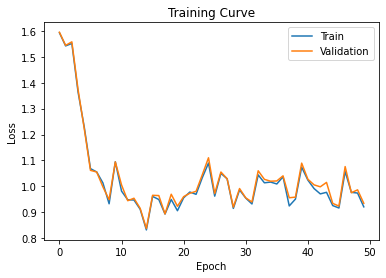

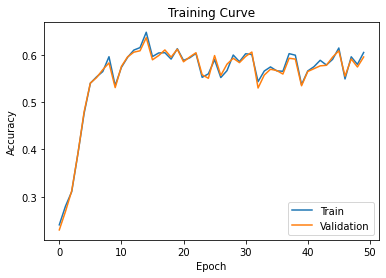

In [39]:
hidden_size = 27
num_classes = 5
batch_size = 16

train_dataloaders = []
valid_dataloaders = []
test_dataloaders = []


for dataset in train_datasets:
    train_dataloaders += [DataLoader(dataset, shuffle=True, batch_size=batch_size)]

for dataset in valid_datasets:
    valid_dataloaders += [DataLoader(dataset, shuffle=True, batch_size=batch_size)]

for dataset in test_datasets:
    test_dataloaders += [DataLoader(dataset, shuffle=True, batch_size=batch_size)]

train = MyLoader(train_dataloaders)
val = MyLoader(valid_dataloaders)
test = MyLoader(test_dataloaders)

model = FinalModel(hidden_size, num_classes)
train_model(model, train, val, num_epochs =50, learning_rate=0.004, batch_size=batch_size)

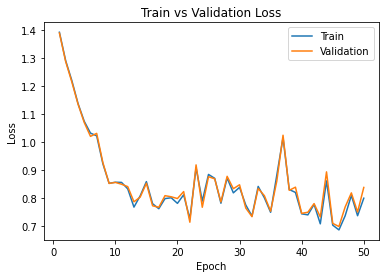

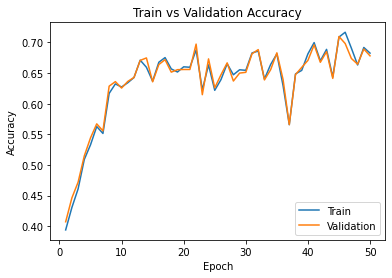

In [ ]:
model_path = get_model_name("final_model", batch_size=16, learning_rate=0.004, epoch=49)
plot_training_curve(model_path)

# Evaluation

In [ ]:
model_loaded = FinalModel(hidden_size, num_classes)
model_path = get_model_name(model_loaded.name, batch_size=16, learning_rate=0.004, epoch=49)
state = torch.load(model_path)
model_loaded.load_state_dict(state)

print('Accuracy of Model: {}'.format(get_accuracy(model_loaded, test)))

Accuracy of Model: 0.6744002109148431


In [ ]:
def get_accuracy_confusion_matrix(model, loader):
    true = []
    pred = []
    for batches in loader:
        for batch in batches:
            sequential, stationary, labels = batch
            labels = labels.type(torch.LongTensor)
            output = model(stationary.float(), sequential.float())
            #select index with maximum prediction score
            prediction = output.max(1, keepdim=True)[1]
            true += [labels.item()]
            pred += [prediction.item()]
    return true, pred

In [ ]:
valid_dataloaders = []
batch_size = 1

for dataset in valid_datasets:
    valid_dataloaders += [DataLoader(dataset, shuffle=True, batch_size=batch_size)]

val = MyLoader(valid_dataloaders)

true, pred = get_accuracy_confusion_matrix(model_loaded, val)

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('RdPu')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
true

[3,
 1,
 0,
 1,
 4,
 3,
 4,
 3,
 3,
 0,
 4,
 3,
 1,
 4,
 1,
 3,
 2,
 2,
 2,
 0,
 1,
 2,
 4,
 3,
 4,
 1,
 3,
 3,
 1,
 4,
 0,
 2,
 3,
 3,
 4,
 1,
 4,
 4,
 2,
 3,
 0,
 0,
 4,
 4,
 2,
 2,
 4,
 1,
 0,
 3,
 2,
 2,
 3,
 4,
 2,
 3,
 2,
 4,
 2,
 2,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 3,
 4,
 0,
 4,
 1,
 3,
 0,
 2,
 4,
 3,
 0,
 1,
 4,
 2,
 4,
 4,
 0,
 0,
 4,
 3,
 4,
 4,
 0,
 2,
 3,
 3,
 0,
 1,
 2,
 4,
 2,
 0,
 3,
 3,
 1,
 0,
 1,
 2,
 3,
 0,
 0,
 4,
 4,
 0,
 2,
 1,
 0,
 4,
 0,
 1,
 4,
 4,
 3,
 2,
 3,
 3,
 3,
 0,
 4,
 1,
 3,
 1,
 3,
 3,
 4,
 2,
 3,
 3,
 1,
 0,
 3,
 0,
 2,
 4,
 4,
 4,
 1,
 0,
 1,
 1,
 3,
 2,
 0,
 1,
 0,
 4,
 0,
 4,
 3,
 1,
 1,
 3,
 0,
 4,
 3,
 1,
 3,
 3,
 4,
 1,
 0,
 1,
 3,
 0,
 3,
 4,
 4,
 2,
 0,
 2,
 3,
 2,
 0,
 0,
 4,
 4,
 1,
 1,
 4,
 0,
 0,
 2,
 4,
 1,
 2,
 3,
 4,
 4,
 0,
 2,
 3,
 4,
 3,
 3,
 4,
 2,
 1,
 2,
 4,
 1,
 0,
 0,
 1,
 4,
 1,
 4,
 3,
 3,
 4,
 2,
 4,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 3,
 0,
 2,
 0,
 4,
 4,
 3,
 4,
 3,
 0,
 1,
 0,
 1,
 1,
 3,
 4,
 3,
 4,
 4,
 3,
 0,
 0,
 1,


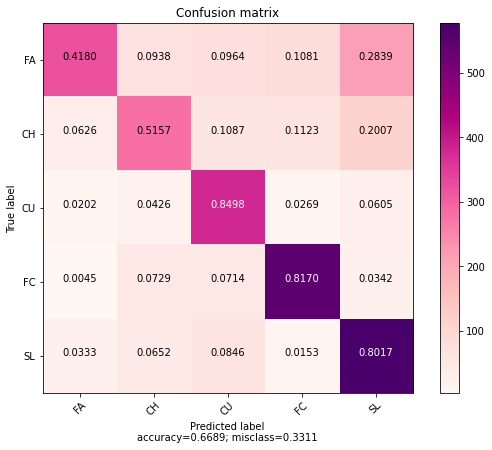

In [ ]:
from sklearn.metrics import confusion_matrix

mul_c = confusion_matrix(true, pred)
plot_confusion_matrix(mul_c, ['FA', 'CH', 'CU', 'FC', 'SL'])

# FA - 4-seamer
# CH - Changeup
# CU - Curveball
# FC - Cutter
# SL - Slider